# TFM - MASTER DATA SCIENCE NUCLIO - CLUSTERING

Se realizan los siguientes estudios:
- **Segmentación de clientes**: segmentación de clientes en base a sus características y comportamientos similares utilizando el algoritmo de clasificación no supervisada K-means. De esta forma se identifican y se obtiene un conocimiento más profundo para realizar campañas de marketing definidas y con éxito.

- **Beneficios de la campaña**: se los modelo de propensión para estimar los beneficios de la campaña.
- **Estudio de las características de la segmentación**: análisis de las características más significativas de los clusters.

## Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

# silence warnings
import warnings
warnings.filterwarnings("ignore")
# operating system
import os
# time calculation to track some processes
import time


# import plotly.express as px
# plt.style.use('ggplot')
# %matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, FunctionTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer

# from sklearn.externals import joblib 

## Cleaning and preprocessing

### Customer commercial activity

In [13]:
cca = pd.read_csv("csv/customer_commercial_activity.csv", sep=",")

In [14]:
cca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Unnamed: 0       int64  
 1   pk_cid           int64  
 2   pk_partition     object 
 3   entry_date       object 
 4   entry_channel    object 
 5   active_customer  float64
 6   segment          object 
dtypes: float64(1), int64(2), object(4)
memory usage: 318.5+ MB


Se observa que la columna Unnamed: 0 no aporta valor ya que es una id que coincide con el nº de filas hasta que se han ido eliminando filas y ha empezado el descuadre

In [15]:
del(cca["Unnamed: 0"])

#### Nulos

In [16]:
cca.isnull().sum()

pk_cid                  0
pk_partition            0
entry_date              0
entry_channel      133033
active_customer         0
segment            133944
dtype: int64

#### entry_date

Se modifica el formato de entry_date a datetime en formato año y mes

In [17]:
cca["entry_date"] = pd.to_datetime(cca["entry_date"], format = "%Y-%m")

#### entry_channel

Imputación de nulos con el valor Desconocido.  
Identificación de valores poco frecuentes (por debajo del 5%) y se reemplazan por Other.  

Ayuda a reducir la cantidad de categorías únicas y evitar el problema de la dimensionalidad alta.

In [18]:
cca["entry_channel"] = cca["entry_channel"].fillna('Desconocido')

vc = cca['entry_channel'].value_counts(normalize=True)
replace_values = vc[vc < 0.05].index
cca['entry_channel'] = cca['entry_channel'].replace(replace_values, 'Other')

cca['entry_channel'].value_counts(normalize=True)

entry_channel
KHE      0.522218
Other    0.159652
KFC      0.149360
KHQ      0.098992
KAT      0.069779
Name: proportion, dtype: float64

#### segment

Cambio del nombre de las categorías de la variable segment para que sean más descriptivas y fáciles de entender.  

Sustitución de los valores nulos por la categoría 'Desconocido'

In [19]:
cca.loc[(cca["segment"] == "01 - TOP"),'segment'] = "TOP"
cca.loc[(cca["segment"] == "02 - PARTICULARES"),'segment'] = "PARTICULARES"
cca.loc[(cca["segment"] == "03 - UNIVERSITARIO"),'segment'] = "UNIVERSITARIO"
cca.value_counts("segment")
cca["segment"] = cca["segment"].fillna('DESCONOCIDO')

In [20]:
pd.to_pickle(cca,"pickle/cca_clean_v2")

### Customer products

In [9]:
cp = pd.read_csv("csv/customer_products.csv", sep=",")

In [21]:
cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 18 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Unnamed: 0          int64  
 1   pk_cid              int64  
 2   pk_partition        object 
 3   short_term_deposit  int64  
 4   loans               int64  
 5   mortgage            int64  
 6   funds               int64  
 7   securities          int64  
 8   long_term_deposit   int64  
 9   em_account_pp       int64  
 10  credit_card         int64  
 11  payroll             float64
 12  pension_plan        float64
 13  payroll_account     int64  
 14  emc_account         int64  
 15  debit_card          int64  
 16  em_account_p        int64  
 17  em_acount           int64  
dtypes: float64(2), int64(15), object(1)
memory usage: 818.9+ MB


In [22]:
cp.isnull().sum()

Unnamed: 0             0
pk_cid                 0
pk_partition           0
short_term_deposit     0
loans                  0
mortgage               0
funds                  0
securities             0
long_term_deposit      0
em_account_pp          0
credit_card            0
payroll               61
pension_plan          61
payroll_account        0
emc_account            0
debit_card             0
em_account_p           0
em_acount              0
dtype: int64

In [23]:
cp.describe(include = np.number ).T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,5962924.0,7.155425e+06,3.920784e+06,0.0,4240385.75,7499346.5,10201422.25,13647308.0
pk_cid,5962924.0,1.234930e+06,1.623020e+05,15891.0,1112532.00,1231097.0,1352339.00,1553689.0
short_term_deposit,5962924.0,2.581619e-03,5.074401e-02,0.0,0.00,0.0,0.00,1.0
loans,5962924.0,7.848498e-05,8.858828e-03,0.0,0.00,0.0,0.00,1.0
mortgage,5962924.0,5.433576e-05,7.371080e-03,0.0,0.00,0.0,0.00,1.0
funds,5962924.0,3.370662e-03,5.795948e-02,0.0,0.00,0.0,0.00,1.0
securities,5962924.0,3.711770e-03,6.081113e-02,0.0,0.00,0.0,0.00,1.0
long_term_deposit,5962924.0,1.688098e-02,1.288255e-01,0.0,0.00,0.0,0.00,1.0
em_account_pp,5962924.0,0.000000e+00,0.000000e+00,0.0,0.00,0.0,0.00,0.0
credit_card,5962924.0,1.188444e-02,1.083660e-01,0.0,0.00,0.0,0.00,1.0


Eliminación de la columna Unnamed: 0 ya que no aporta valor ya que es una id que coincide con el nº de filas hasta que se han ido eliminando filas y ha empezado el descuadre.  

Eliminación de la columna em_account_pp porque todos sus valores son 0 y no aporta valor.

In [24]:
del(cp['Unnamed: 0'])
del(cp['em_account_pp'])

#### payroll

Se eliminan los nulos de payroll debido a que son un número reducido y no aportan valor al análisis.

In [25]:
cp.dropna(subset=["payroll"], inplace = True)
cp.isnull().sum()

pk_cid                0
pk_partition          0
short_term_deposit    0
loans                 0
mortgage              0
funds                 0
securities            0
long_term_deposit     0
credit_card           0
payroll               0
pension_plan          0
payroll_account       0
emc_account           0
debit_card            0
em_account_p          0
em_acount             0
dtype: int64

#### pension_plan

Se convierte payroll y pension_plan a entero.

In [27]:
cp['payroll'] = cp['payroll'].astype(int)
cp['pension_plan'] = cp['pension_plan'].astype(int)

La función getAltas tiene el objetivo de identificar las "altas" (contrataciones nuevas) de un producto específico para cada cliente.

In [58]:
def getAltas(df: pd.DataFrame, product: str)-> pd.DataFrame:

    df[f'{product}_alta'] = df.groupby('pk_cid')[product].transform(
        lambda x: (x.shift(1) == 0) & (x == 1)
    ).astype(int)

    return df

La función getBajas tiene el objetivo de identificar las "bajas" de un producto específico para cada cliente.

In [59]:
def getBajas(df: pd.DataFrame, product: str)-> pd.DataFrame:

    df[f'{product}_baja'] = df.groupby('pk_cid')[product].transform(
        lambda x: (x.shift(1) == 1) & (x == 0)
    ).astype(int)

    return df

In [60]:
product_list = [
    'short_term_deposit', 
    'loans', 
    'mortgage',
    'funds', 
    'securities', 
    'long_term_deposit', 
    'credit_card', 
    'payroll',
    'pension_plan', 
    'payroll_account', 
    'emc_account', 
    'debit_card',
    'em_account_p', 
    'em_acount'
]

In [61]:
for product in product_list:
    cp = getAltas(cp, product)
    cp = getBajas(cp, product)

La función countMonths calcula el número de meses transcurridos desde la última alta (nueva contratación).

In [91]:
def countMonths(series: pd.Series) -> pd.Series:
    meses_desde_alta = []
    contador = 0
    flag = False
    for value in series:
        if value == 1:
            contador = 0  # Reiniciar el contador al dar de alta
            flag = True
        elif value == 0 and flag:
            contador += 1  # Incrementar el contador si sigue dado de baja

        meses_desde_alta.append(contador)

    return pd.Series(meses_desde_alta, index=series.index)

Se calcula el tiempo transcurrido desde la última alta y la última baja de cada producto en la lista product_list para cada cliente.

In [92]:
for product in product_list:
    cp[f'{product}_last_alta'] = cp.groupby('pk_cid')[f'{product}_alta'].transform(
        lambda series: countMonths(series)
    )
    cp[f'{product}_last_baja'] = cp.groupby('pk_cid')[f'{product}_baja'].transform(
        lambda series: countMonths(series)
    )


Se revisa la información de un cliente para verificar el correcto funcionamiento.

In [96]:
df = cp[['pk_cid', 'pk_partition', 'loans', 'loans_alta', 'loans_last_alta', 'loans_last_baja']]

In [97]:
df[df['pk_cid'] == 1134495]

,pk_cid,pk_partition,loans,loans_alta,loans_last_alta,loans_last_baja
185619,1134495,2018-01,0,0,0,0
433018,1134495,2018-02,0,0,0,0
673352,1134495,2018-03,0,0,0,0
917538,1134495,2018-04,0,0,0,0
1033617,1134495,2018-05,0,0,0,0
1278926,1134495,2018-06,0,0,0,0
1559407,1134495,2018-07,0,0,0,0
2033784,1134495,2018-08,0,0,0,0
2371687,1134495,2018-09,0,0,0,0
2615407,1134495,2018-10,0,0,0,0


In [95]:
pd.to_pickle(cp,"pickle/cp_clean_v2")

### Customer sociodemographics

In [231]:
cs = pd.read_csv("csv/customer_sociodemographics.csv", sep=",")

In [232]:
cs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Unnamed: 0    int64  
 1   pk_cid        int64  
 2   pk_partition  object 
 3   country_id    object 
 4   region_code   float64
 5   gender        object 
 6   age           int64  
 7   deceased      object 
 8   salary        float64
dtypes: float64(2), int64(3), object(4)
memory usage: 409.4+ MB


In [233]:
cs.isnull().sum()

Unnamed: 0            0
pk_cid                0
pk_partition          0
country_id            0
region_code        2264
gender               25
age                   0
deceased              0
salary          1541104
dtype: int64

#### region_code y gender

In [234]:
del(cs["Unnamed: 0"])

Se eliminan los nulos de region_code y gender debido a que son un número reducido y no aportan valor.

In [235]:
cs.dropna(subset=["region_code"], inplace = True)

cs.dropna(subset=["gender"], inplace = True)

cs.isnull().sum()

pk_cid                0
pk_partition          0
country_id            0
region_code           0
gender                0
age                   0
deceased              0
salary          1538877
dtype: int64

#### deceased

In [236]:
cs["deceased"].value_counts(normalize=True)

deceased
N    0.99982
S    0.00018
Name: proportion, dtype: float64

Eliminamos los clientes fallecidos

In [237]:
unique_deceased_customers = cs[cs['deceased'] == 1]['pk_cid'].unique()

cs.drop(cs[cs['pk_cid'].isin(unique_deceased_customers)].index, inplace=True)

In [238]:
cs.columns.to_list()

['pk_cid',
 'pk_partition',
 'country_id',
 'region_code',
 'gender',
 'age',
 'deceased',
 'salary']

#### country_id, region_code, gender

Se elimina la variable country_id porque solo hay clientes de España.  
Se elimina la variable region_code porque no aporta valor ni variabilidad al modelo.  
Se elimina la variable gender porque no aporta valor ni variabilidad al modelo.  
Se elimina la variable deceased porque ya hemos eliminado los clientes fallecidos.  

In [239]:
COLUMNS_TO_DROP = [
    'country_id',
    'region_code',
    'gender',
    'deceased'
]
cs = cs.drop(COLUMNS_TO_DROP, axis=1)

In [240]:
pd.to_pickle(cs,"pickle/cs_clean_v2")

### Product description

In [112]:
pde = pd.read_csv('csv/product_description.csv', sep=",")

In [113]:
pde.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      13 non-null     int64 
 1   pk_product_ID   13 non-null     int64 
 2   product_desc    13 non-null     object
 3   family_product  13 non-null     object
dtypes: int64(2), object(2)
memory usage: 548.0+ bytes


Eliminamos Unnamed: 0

In [114]:
del(pde["Unnamed: 0"])

In [115]:
pd.to_pickle(pde,"pickle/pde_clean_v2")

### Sales

In [116]:
s = pd.read_csv('csv/sales.csv', sep=",")

In [117]:
s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240773 entries, 0 to 240772
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  240773 non-null  int64  
 1   pk_sale     240773 non-null  int64  
 2   cid         240773 non-null  int64  
 3   month_sale  240773 non-null  object 
 4   product_ID  240773 non-null  int64  
 5   net_margin  240773 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 11.0+ MB


Eliminamos Unnamedmed: 0

In [118]:
del(s['Unnamed: 0'])

In [119]:
s['month_sale'] = pd.to_datetime(s['month_sale'])

In [120]:
pd.to_pickle(s,"pickle/s_clean_v2")

### Union dataframes

In [241]:
cca_clean = pd.read_pickle('pickle/cca_clean_v2')
cp_clean = pd.read_pickle('pickle/cp_clean_v2')
cs_clean = pd.read_pickle('pickle/cs_clean_v2')
pde_clean = pd.read_pickle('pickle/pde_clean_v2')
s_clean = pd.read_pickle('pickle/s_clean_v2')

In [242]:
df_merge1 = pd.merge(cca_clean,cp_clean,on=["pk_cid","pk_partition"],how="inner")
df_clientes = pd.merge(df_merge1,cs_clean,on=["pk_cid","pk_partition"],how="inner")
df_ventas = pd.merge(s_clean,pde_clean,left_on='product_ID',right_on="pk_product_ID",how="inner")

In [243]:
del cca_clean, cp_clean, cs_clean, pde_clean, s_clean, df_merge1

In [244]:
df_clientes['pk_partition'] = pd.to_datetime(df_clientes['pk_partition'])

In [245]:
df_merge4 = pd.merge(df_clientes,df_ventas,left_on=["pk_cid","pk_partition"],right_on= ['cid','month_sale'], how="left")

In [246]:
del df_clientes, df_ventas

Cálculo del margen total del cliente.

In [247]:
# Margen total del cliente
df_merge4['net_margin'] = df_merge4['net_margin'].fillna(0)
df_merge4['net_margin'] = df_merge4.groupby('pk_cid')['net_margin'].transform('sum')

Groupby por cliente y mes para agrupar los productos que tiene cada cliente.

In [248]:
df = df_merge4.groupby(['pk_cid', 'pk_partition']).agg(
    {col: 'first' for col in df_merge4.columns if col != 'product_desc'} |
    {'product_desc': 'count'}
).reset_index(drop=True)

In [249]:
print(df_merge4.columns.to_list())

['pk_cid', 'pk_partition', 'entry_date', 'entry_channel', 'active_customer', 'segment', 'short_term_deposit', 'loans', 'mortgage', 'funds', 'securities', 'long_term_deposit', 'credit_card', 'payroll', 'pension_plan', 'payroll_account', 'emc_account', 'debit_card', 'em_account_p', 'em_acount', 'loans_alta', 'short_term_deposit_alta', 'short_term_deposit_baja', 'loans_baja', 'mortgage_alta', 'mortgage_baja', 'funds_alta', 'funds_baja', 'securities_alta', 'securities_baja', 'long_term_deposit_alta', 'long_term_deposit_baja', 'credit_card_alta', 'credit_card_baja', 'payroll_alta', 'payroll_baja', 'pension_plan_alta', 'pension_plan_baja', 'payroll_account_alta', 'payroll_account_baja', 'emc_account_alta', 'emc_account_baja', 'debit_card_alta', 'debit_card_baja', 'em_account_p_alta', 'em_account_p_baja', 'em_acount_alta', 'em_acount_baja', 'loans_last_alta', 'short_term_deposit_last_alta', 'short_term_deposit_last_baja', 'loans_last_baja', 'mortgage_last_alta', 'mortgage_last_baja', 'funds_l

Listas de productos a los que se va a realizar las agregaciones específicas para generar como salida un dataframe con una fila por cada cliente (pk_cid), agregando los datos según lo especificado en agg_dict.

In [250]:
COLUMNS_TO_SUM = [
    'active_customer',
    'short_term_deposit',
    'loans',
    'mortgage',
    'funds',
    'securities',
    'long_term_deposit',
    'credit_card',
    'payroll',
    'pension_plan',
    'payroll_account',
    'emc_account',
    'debit_card',
    'em_account_p',
    'em_acount',
    'loans_alta', 
    'short_term_deposit_alta', 
    'short_term_deposit_baja', 
    'loans_baja', 
    'mortgage_alta', 
    'mortgage_baja', 
    'funds_alta', 
    'funds_baja', 
    'securities_alta', 
    'securities_baja', 
    'long_term_deposit_alta', 
    'long_term_deposit_baja', 
    'credit_card_alta', 
    'credit_card_baja', 
    'payroll_alta', 
    'payroll_baja', 
    'pension_plan_alta', 
    'pension_plan_baja', 
    'payroll_account_alta', 
    'payroll_account_baja', 
    'emc_account_alta', 
    'emc_account_baja', 
    'debit_card_alta', 
    'debit_card_baja', 
    'em_account_p_alta', 
    'em_account_p_baja', 
    'em_acount_alta', 
    'em_acount_baja',
    'product_desc'
]

COLUMNS_TO_LAST = [
    'loans_last_alta', 
    'short_term_deposit_last_alta', 
    'short_term_deposit_last_baja', 
    'loans_last_baja', 
    'mortgage_last_alta', 
    'mortgage_last_baja', 
    'funds_last_alta', 
    'funds_last_baja', 
    'securities_last_alta', 
    'securities_last_baja', 
    'long_term_deposit_last_alta', 
    'long_term_deposit_last_baja', 
    'credit_card_last_alta', 
    'credit_card_last_baja', 
    'payroll_last_alta', 
    'payroll_last_baja', 
    'pension_plan_last_alta', 
    'pension_plan_last_baja', 
    'payroll_account_last_alta', 
    'payroll_account_last_baja', 
    'emc_account_last_alta', 
    'emc_account_last_baja', 
    'debit_card_last_alta', 
    'debit_card_last_baja', 
    'em_account_p_last_alta', 
    'em_account_p_last_baja', 
    'em_acount_last_alta', 
    'em_acount_last_baja',
]

In [ ]:
# Diccionario de agregación
agg_dict = {
    'pk_cid': 'first',
    'entry_date': 'first',
    'net_margin': 'first',
    'age': 'first',
    'salary' : 'last',
    'entry_channel': lambda x: x.mode()[0],
}

# Columnas a sumar
agg_dict.update({col: 'sum' for col in COLUMNS_TO_SUM})

# Columnas a obtener el último valor
agg_dict.update({col: 'last' for col in COLUMNS_TO_LAST})

In [252]:
df2 = df.groupby('pk_cid').agg(agg_dict).reset_index(drop=True)

Total de altas y bajas por cliente, y el último mes de alta y baja para cada producto.

In [253]:
ALTAS = [
    'loans_alta', 
    'short_term_deposit_alta', 
    'mortgage_alta', 
    'funds_alta', 
    'securities_alta', 
    'long_term_deposit_alta', 
    'credit_card_alta', 
    'payroll_alta', 
    'pension_plan_alta', 
    'payroll_account_alta', 
    'emc_account_alta', 
    'debit_card_alta', 
    'em_account_p_alta', 
    'em_acount_alta'
]

BAJAS = [
    'short_term_deposit_baja', 
    'loans_baja', 
    'mortgage_baja', 
    'funds_baja',  
    'securities_baja', 
    'long_term_deposit_baja',
    'credit_card_baja', 
    'payroll_baja',  
    'pension_plan_baja', 
    'payroll_account_baja', 
    'emc_account_baja', 
    'debit_card_baja', 
    'em_account_p_baja', 
    'em_acount_baja'
]

LAST_ALTA = [
    'loans_last_alta', 
    'short_term_deposit_last_alta', 
    'mortgage_last_alta', 
    'funds_last_alta', 
    'securities_last_alta',  
    'long_term_deposit_last_alta',  
    'credit_card_last_alta', 
    'payroll_last_alta', 
    'pension_plan_last_alta',  
    'payroll_account_last_alta',  
    'emc_account_last_alta', 
    'debit_card_last_alta',  
    'em_account_p_last_alta',  
    'em_acount_last_alta'
]

LAST_BAJA = [
    'short_term_deposit_last_baja', 
    'loans_last_baja', 
    'mortgage_last_baja', 
    'funds_last_baja', 
    'securities_last_baja', 
    'long_term_deposit_last_baja', 
    'credit_card_last_baja', 
    'payroll_last_baja',  
    'pension_plan_last_baja', 
    'payroll_account_last_baja', 
    'emc_account_last_baja', 
    'debit_card_last_baja', 
    'em_account_p_last_baja', 
    'em_acount_last_baja'
]

In [254]:
df2['altas'] = df[ALTAS].sum(axis=1)
df2['bajas'] = df[BAJAS].sum(axis=1)

In [255]:
# Función para obtener el mínimo diferente de 0, o 0 si todos son 0
def min_non_zero(row):
    # Filtrar los valores diferentes de 0
    non_zero_values = row[row != 0]
    # Si hay valores no nulos, devolver el mínimo, de lo contrario devolver 0
    return non_zero_values.min() if not non_zero_values.empty else 0

Agregación de dos nuevas columnas al DataFrame, last_alta y last_baja, que representan el valor mínimo distinto de cero en las columnas de LAST_ALTA y LAST_BAJA, para cada fila.

In [256]:
df2['last_alta'] = df2[LAST_ALTA].apply(min_non_zero, axis=1)
df2['last_baja'] = df2[LAST_BAJA].apply(min_non_zero, axis=1)

In [257]:
df3 = df2[['pk_cid', 'altas', 'bajas', 'last_alta', 'last_baja']]

In [258]:
df3 = df2.copy()

In [259]:
COLUMNS_TO_DROP = ALTAS + BAJAS + LAST_ALTA + LAST_BAJA
df2 = df2.drop(COLUMNS_TO_DROP, axis=1)

In [260]:
df2['products'] = df2[['short_term_deposit', 'loans', 'mortgage', 'funds', 'securities', 'long_term_deposit', 'credit_card', 'payroll', 'pension_plan', 'payroll_account', 'emc_account', 'debit_card', 'em_account_p', 'em_acount']].sum(axis=1)

Se eliminan las variables que no interesan para la realización del clustering.

In [261]:
COLUMNS_TO_DROP = {
    'short_term_deposit',
    'loans',
    'mortgage',
    'funds',
    'securities',
    'long_term_deposit',
    'credit_card',
    'payroll',
    'pension_plan',
    'payroll_account',
    'emc_account',
    'debit_card',
    'em_account_p',
    'em_acount'
}
df2 = df2.drop(columns=COLUMNS_TO_DROP, axis=1)

In [262]:
df2 = df2.rename(columns={"product_desc":"sales"})

Antigüedad del cliente desde la fecha en la que realizó la primera contratación.

In [263]:
date = df2['entry_date'].max()
df2['entry_date_diff'] = (date - df2['entry_date']).dt.days


In [264]:
del(df2['entry_date'])

In [265]:
df2

,pk_cid,net_margin,age,salary,entry_channel,active_customer,sales,altas,bajas,last_alta,last_baja,products,entry_date_diff
0,15891,66.4,59,NaN,KAT,1.0,1,0,0,0,0,1,304
1,16063,0.0,62,NaN,KAT,5.0,0,0,1,0,0,0,181
2,16203,96.7,70,NaN,KAT,5.0,1,0,0,4,0,5,151
3,16502,132.9,57,NaN,Other,8.0,2,0,0,4,0,13,242
4,17457,56.0,53,102405.75,KAT,17.0,1,0,0,6,1,38,607
...,...,...,...,...,...,...,...,...,...,...,...,...,...
456220,1553685,0.0,52,NaN,Other,0.0,0,0,0,0,0,0,0
456221,1553686,0.0,30,NaN,Other,0.0,0,0,0,0,0,0,0
456222,1553687,0.0,21,NaN,Other,0.0,0,0,0,0,0,0,0
456223,1553688,0.0,43,NaN,Other,0.0,0,0,0,0,0,0,0


In [266]:
pd.to_pickle(df2,"pickle/df_clustering_v1")

## Clustering

In [2]:
df = pd.read_pickle("pickle/df_clustering_v1")

In [3]:
del[df['entry_channel']]

In [4]:
df = df.set_index('pk_cid')

La columna salary tiene una gran cantidad de valores nulos, por lo que se debe ser cuidadoso al decidir cómo proceder.  
Se imputará la mediana del salario de cada grupo de edad para mantener una relación lógica entre la edad y el salario.  
Tiene sentido porque el salario está relacionado con la edad.  
También reduce el sesgo hacia cero.  
Mejora la variabilidad necesaria para segmentar correctamente y sustituir por un valor -1 podría influir en la clusterización.

In [5]:
df['salary'] = df.groupby('age')['salary'].transform(lambda x: x.fillna(x.median()))

Si aún hay valores nulos (por ejemplo, edades con pocos datos), imputamos con la mediana global

In [6]:
df['salary'].fillna(df['salary'].median(), inplace=True)
df.isnull().sum()

net_margin         0
age                0
salary             0
active_customer    0
sales              0
altas              0
bajas              0
last_alta          0
last_baja          0
products           0
entry_date_diff    0
dtype: int64

In [7]:
df.head()

,net_margin,age,salary,active_customer,sales,altas,bajas,last_alta,last_baja,products,entry_date_diff
pk_cid,,,,,,,,,,,
15891,66.4,59,97193.67,1.0,1,0,0,0,0,1,304
16063,0.0,62,110236.92,5.0,0,0,1,0,0,0,181
16203,96.7,70,111957.96,5.0,1,0,0,4,0,5,151
16502,132.9,57,99277.35,8.0,2,0,0,4,0,13,242
17457,56.0,53,102405.75,17.0,1,0,0,6,1,38,607


### Pipeline

Se crea un pipeline para imputar los valores faltantes y escalar los datos.  
En RobustScaler se utilizan valores entre el percentil 0 y el 99 para escalar los datos, lo que permite reducir la influencia de los valores atípicos o outliers.

In [8]:
pipe = Pipeline(steps = [
    #("Imputer", KNNImputer()),
    ("RobustScaler", RobustScaler(quantile_range = (0, 99.0)))
])

In [9]:
df_scaled = pipe.fit_transform(df)

### Gráfico de la curva del codo 

Se utiliza el gráfico de la curva del codo para definir K (número de clusters) del modelo K-Means buscando detectar cuando hay un cambio brusco en la inercia.  

Para definir la K (número de clusters) usamos CURVA DEL CODO. Se busca detectar cuando hay un cambio brusco en la inercia. La inercia es la suma de las distancias al cuadrado de los puntos de cada cluster a su centroide. Cuanto más pequeña sea la inercia, mejor será el modelo. Pero si se añaden más clusters, la inercia siempre disminuirá. Por lo que se debe encontrar el punto en el que la disminución de la inercia se estabiliza.  

Se utilizará un rango para k entre 2 y 8.  

In [10]:
sse = {}

for k in range(2, 9):

    print(f"Fitting pipe with {k} clusters")

    clustering_model = KMeans(n_clusters = k)
    clustering_model.fit(df_scaled)

    sse[k] = clustering_model.inertia_

Fitting pipe with 2 clusters
Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters
Fitting pipe with 6 clusters
Fitting pipe with 7 clusters
Fitting pipe with 8 clusters


Text(0.5, 0.98, 'Variación de la dispersión de los clústers en función de la k')

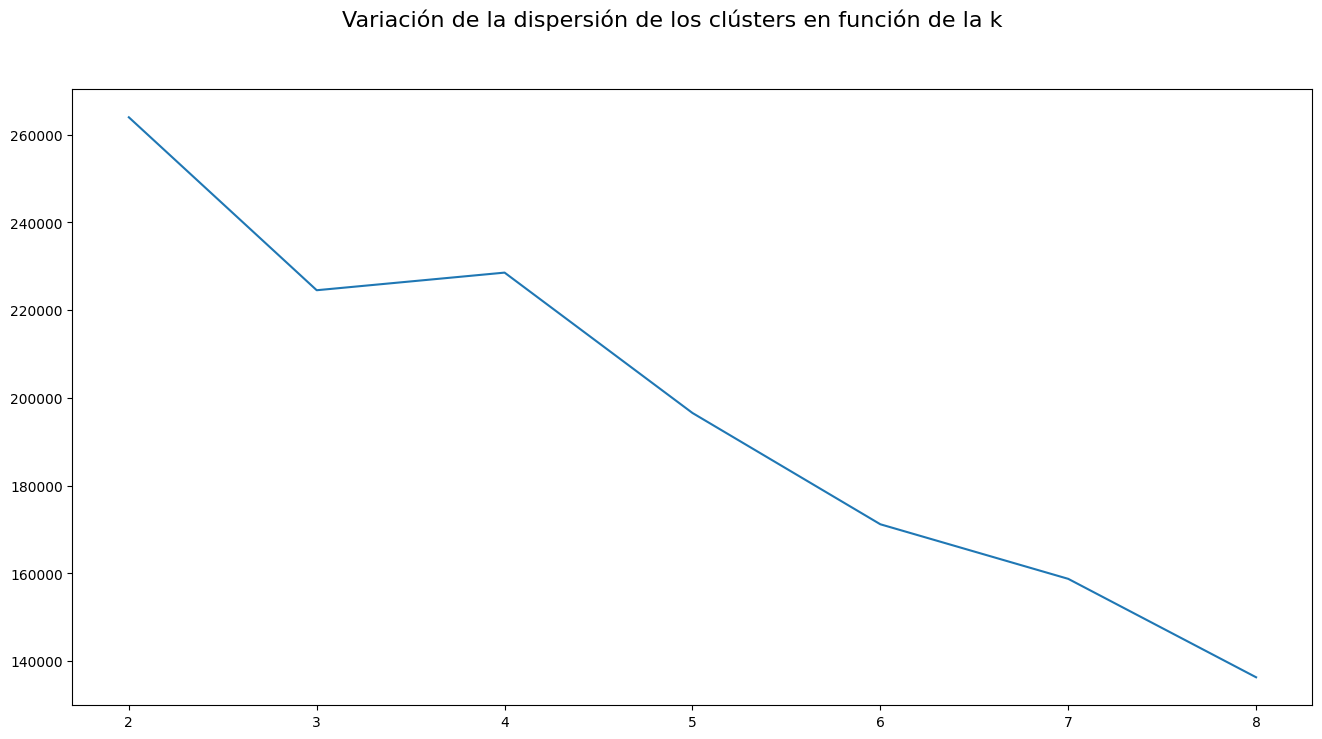

In [11]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot()

x_values = list(sse.keys())
y_values = list(sse.values())

ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")
fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize = 16)

In [12]:
pipe = Pipeline(steps = [
    # ("Imputer", KNNImputer()),
    ("RobustScaler", RobustScaler(quantile_range = (0, 99.0))),
    ("Clustering", KMeans(n_clusters = 4, random_state = 175))
])

In [13]:
pipe.fit(df)

Pipeline(steps=[('RobustScaler', RobustScaler(quantile_range=(0, 99.0))),
                ('Clustering', KMeans(n_clusters=4, random_state=175))])

In [14]:
X_processed = df

In [15]:
labels = pipe.predict(df)

In [16]:
# le asignamos al DataFrame procesado el clúster.
# si lo hacemos al df escalado será más díficil de interpretar los resultados porque los números están escalados
X_processed["cluster"] = labels

In [17]:
X_processed.shape

(456225, 12)

### Ficha de clientes

In [18]:
metricas_a_analizar=[
    'net_margin',
    'age',
    'salary',
    'active_customer',
    'sales',  
    'last_alta',
    'last_baja',
    'products',
    'entry_date_diff'
]

ficha = pd.DataFrame()
for i, col in enumerate(metricas_a_analizar):
    resumen_data = X_processed[["cluster", col]].groupby("cluster").describe().T[1:]
    ficha = pd.concat([ficha, resumen_data])

In [19]:
pd.set_option('display.max_rows', None) 

In [20]:
ficha

cluster                          0             1             2             3
net_margin      mean  2.644222e+03  3.109560e+01  8.328208e+01  4.495654e+00
                std   3.212219e+03  2.172014e+02  4.601041e+02  1.327898e+02
                min   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
                25%   6.530000e+01  0.000000e+00  0.000000e+00  0.000000e+00
                50%   9.924500e+02  0.000000e+00  0.000000e+00  0.000000e+00
                75%   5.082475e+03  0.000000e+00  7.180000e+01  0.000000e+00
                max   1.864990e+04  1.042860e+04  1.176990e+04  1.077350e+04
age             mean  3.721993e+01  3.252696e+01  2.832055e+01  2.775785e+01
                std   1.366952e+01  1.376043e+01  1.207099e+01  9.716462e+00
                min   3.000000e+00  2.000000e+00  2.000000e+00  3.000000e+00
                25%   2.700000e+01  2.200000e+01  2.000000e+01  2.200000e+01
                50%   3.450000e+01  2.800000e+01  2.200000e+01  2.400000e+01
                75%   4.400000e+01  4.000000e+01  3.300000e+01  2.800000e+01
                max   1.030000e+02  1.020000e+02  1.020000e+02  1.040000e+02
salary          mean  1.114049e+05  1.114455e+05  9.562317e+04  1.183703e+05
                std   1.201370e+05  1.446316e+05  4.968578e+04  2.690963e+05
                min   5.163750e+03  3.796860e+03  3.731790e+03  1.202730e+03
                25%   7.048707e+04  7.035735e+04  8.463100e+04  6.713835e+04
                50%   8.909001e+04  8.920791e+04  8.909001e+04  8.909001e+04
                75%   1.216674e+05  1.206603e+05  9.269046e+04  1.219950e+05
                max   9.833873e+06  1.326862e+07  1.536265e+06  2.889440e+07
active_customer mean  1.330961e+01  1.625656e+01  1.924358e+00  1.724832e-01
                std   4.673319e+00  1.846866e+00  3.256260e+00  1.002436e+00
                min   0.000000e+00  7.000000e+00  0.000000e+00  0.000000e+00
                25%   1.000000e+01  1.700000e+01  0.000000e+00  0.000000e+00
                50%   1.600000e+01  1.700000e+01  0.000000e+00  0.000000e+00
                75%   1.700000e+01  1.700000e+01  3.000000e+00  0.000000e+00
                max   1.700000e+01  1.700000e+01  1.200000e+01  1.700000e+01
sales           mean  2.327475e+00  2.220574e-01  5.756389e-01  1.802369e-02
                std   1.557198e+00  4.908382e-01  6.834336e-01  1.554990e-01
                min   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
                25%   1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
                50%   2.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
                75%   3.000000e+00  0.000000e+00  1.000000e+00  0.000000e+00
                max   1.000000e+01  3.000000e+00  6.000000e+00  5.000000e+00
last_alta       mean  7.165524e+00  6.165330e-01  5.067929e-01  5.657272e-02
                std   4.076331e+00  1.524837e+00  1.622404e+00  5.754539e-01
                min   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
                25%   4.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
                50%   7.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
                75%   1.000000e+01  0.000000e+00  0.000000e+00  0.000000e+00
                max   1.500000e+01  1.200000e+01  1.500000e+01  1.500000e+01
last_baja       mean  5.343201e+00  7.792142e-01  2.730189e-01  1.738949e-01
                std   4.303004e+00  1.975870e+00  1.356004e+00  1.269420e+00
                min   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
                25%   1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
                50%   5.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
                75%   9.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
                max   1.500000e+01  1.500000e+01  1.500000e+01  1.500000e+01
products        mean  2.975840e+01  2.335827e+01  6.600912e+00  1.173617e+01
                std   1.783568e+01  1.467146e+01  6.207683e+00  7.885105e

In [21]:
df_resumen=X_processed.groupby('cluster').agg({     
    'net_margin':np.mean,
    'age':np.mean,
    'salary':np.mean,
    'active_customer':np.mean,
    'sales': np.mean,
    'last_alta':np.mean,
    'last_baja':np.mean,
    'products':np.mean,
    'entry_date_diff':np.mean,
    'cluster':len 
})

df_resumen.rename(columns={"cluster":'Numero de clientes por cluster'},inplace=True)
df_resumen

,net_margin,age,salary,active_customer,sales,last_alta,last_baja,products,entry_date_diff,Numero de clientes por cluster
cluster,,,,,,,,,,
0,2644.222012,37.219930,111404.947038,13.309610,2.327475,7.165524,5.343201,29.758403,697.855644,48138
1,31.095599,32.526957,111445.499235,16.256555,0.222057,0.616533,0.779214,23.358271,949.232383,84933
2,83.282083,28.320550,95623.170331,1.924358,0.575639,0.506793,0.273019,6.600912,320.344901,186445
3,4.495654,27.757851,118370.331256,0.172483,0.018024,0.056573,0.173895,11.736170,1118.400844,136709


Cluster 0: Clientes rentables y activos, con antigüedad y alto margen neto.

Cluster 1: Clientes con antigüedad alta y actividad moderada, nivel de margen medio.

Cluster 2: Grupo grande, con baja antigüedad y menor actividad.

Cluster 3: Clientes con salario alto, muy baja actividad, y clientes más antiguos.

Cluster 0: "Premium Activo"
Descripción: Clientes rentables, con buena antigüedad y alta actividad.
Enfoque de Marketing: Ofrecer productos exclusivos y recompensas por lealtad, así como servicios personalizados que mantengan su nivel de satisfacción y compromiso.

Cluster 1: "Consolidado Selecto"
Descripción: Clientes de antigüedad alta y actividad moderada, con un margen neto medio.
Enfoque de Marketing: Propuestas de valor que refuercen su lealtad y promuevan el uso de nuevos productos, con beneficios por ser clientes de largo plazo.

Cluster 2: "Jóvenes en Crecimiento"
Descripción: Grupo grande, con baja antigüedad y moderada actividad, pero potencial de crecimiento en margen.
Enfoque de Marketing: Campañas que inviten a explorar más productos del banco, como seguros, inversiones o tarjetas premium, a medida que crecen en sus carreras.

Cluster 3: "Ocasionales de Alto Ingreso"
Descripción: Clientes con salario alto pero baja actividad y alta antigüedad.
Enfoque de Marketing: Ofrecer servicios premium de baja fricción, como inversiones a medida o asesoría patrimonial, que los inviten a utilizar más los productos sin requerir mucha interacción.

In [22]:
ficha = ficha.rename(columns = {
    0 : "Premium Activo",
    1 : "Consolidado Selecto",
    2 : "Jóvenes en Crecimiento",
    3 : "Ocasionales de Alto Ingreso",
 })

In [23]:
ficha.style.background_gradient(cmap = 'Blues', axis = 1)

In [24]:
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')

## Calculo de beneficios

In [25]:
pde_clean = pd.read_pickle('pickle/pde_clean_v2')
s_clean = pd.read_pickle('pickle/s_clean_v2')
df_ventas = pd.merge(s_clean,pde_clean,left_on='product_ID',right_on="pk_product_ID",how="inner")

### Pension plan

In [32]:
df_top_pension_plan = pd.read_pickle('pickle/df_top_pension_plan')

Reparto de clientes propensos a comprar pensión plan por cluster.

In [34]:
df_pension_plan= pd.merge(X_processed, df_top_pension_plan, left_index=True, right_index=True, how='inner')
df_pension_plan['cluster'].value_counts(normalize=True)*100

cluster
2    94.521739
0     4.152174
3     0.847826
1     0.478261
Name: proportion, dtype: float64

Miramos a cuantos clientes impactamos que suman 4348.

In [35]:
df_pension_plan_c2 = df_pension_plan[df_pension_plan['cluster'] == 2]
df_pension_plan_c2.shape

(4348, 13)

Ganancias esperadas.

In [36]:
df_ventas_pension_plan = df_ventas[df_ventas['product_desc'] == 'pension_plan']
margin_pension_plan = df_ventas_pension_plan['net_margin'].mean()
beneficios = margin_pension_plan*df_pension_plan_c2['Probability']
beneficios.sum()

23933628.0

Beneficio por unidad de producto.

In [37]:
margin_pension_plan

5976.435907894057

### Debit card

In [42]:
df_top_debit_card = pd.read_pickle('pickle/df_top_debit_card')

Reparto de clientes propensos a comprar tarjetas de debito por cluster.

In [43]:
df_debit_card= pd.merge(X_processed, df_top_debit_card, left_index=True, right_index=True, how='inner')
df_debit_card['cluster'].value_counts(normalize=True)*100

cluster
2    85.771358
0    10.832821
3     3.380455
1     0.015366
Name: proportion, dtype: float64

Cantidad de clientes del cluster 2 al que impacta la 

In [44]:
df_debit_card_c2 = df_debit_card[df_debit_card['cluster'] == 2]
df_debit_card_c2.shape

(5582, 13)

Ganancias esperadas.

In [45]:
df_ventas_debit_card = df_ventas[df_ventas['product_desc'] == 'debit_card']
margin_debit_card = df_ventas_debit_card['net_margin'].mean()
beneficios = margin_debit_card * df_debit_card_c2['Probability']
beneficios.sum()

315026.62

Beneficio por unidad de producto.

In [46]:
margin_debit_card

60.0032157569516

### Gráficos cluster

#### Edad Media por Cluster

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
X_processed.head(2)

,net_margin,age,salary,active_customer,sales,altas,bajas,last_alta,last_baja,products,entry_date_diff,cluster
pk_cid,,,,,,,,,,,,
15891,66.4,59,97193.67,1.0,1,0,0,0,0,1,304,2
16063,0.0,62,110236.92,5.0,0,0,1,0,0,0,181,2


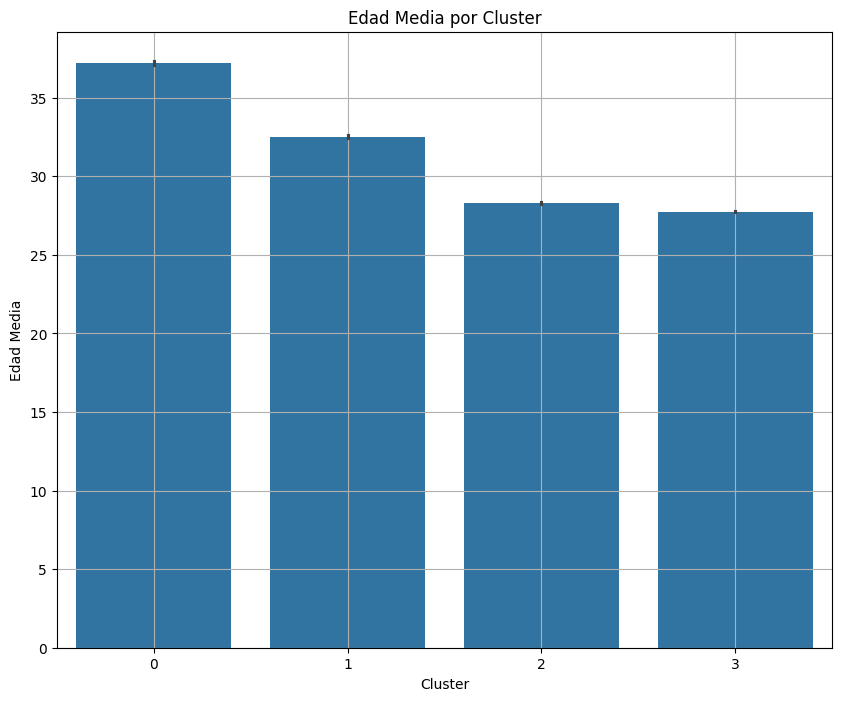

In [48]:
plt.figure(figsize=(10, 8))
sns.barplot(x='cluster', y='age', data=X_processed, estimator=np.mean)
plt.title('Edad Media por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Edad Media')
plt.grid(True)
plt.show()

#### Distribución del Salario por Cluster

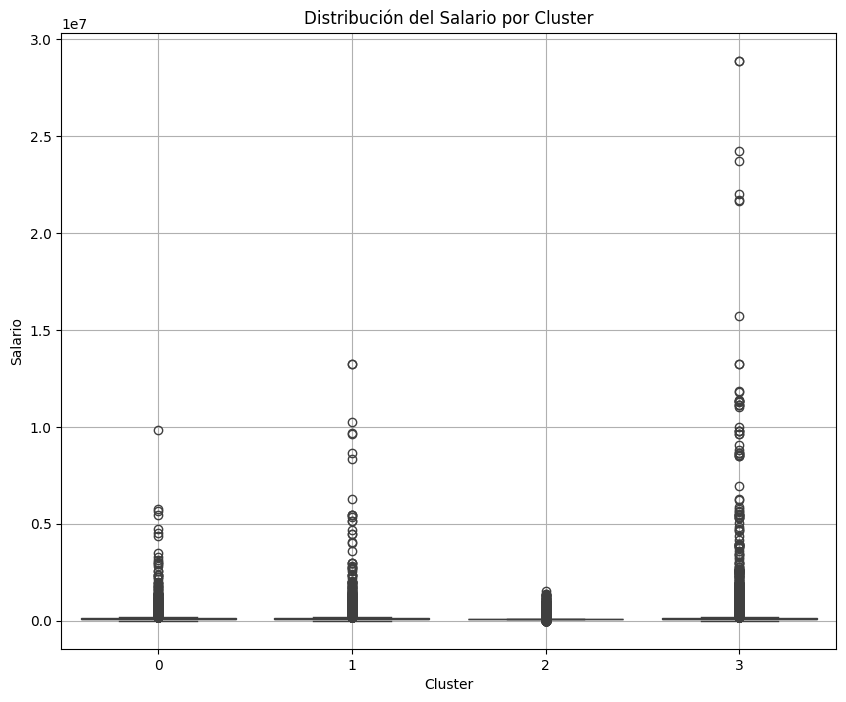

In [51]:
plt.figure(figsize=(10, 8))
sns.boxplot(x='cluster', y='salary', data=X_processed)
plt.title('Distribución del Salario por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Salario')
plt.grid(True)
plt.show()

#### Distribución de la Antigüedad del cliente por Cluster

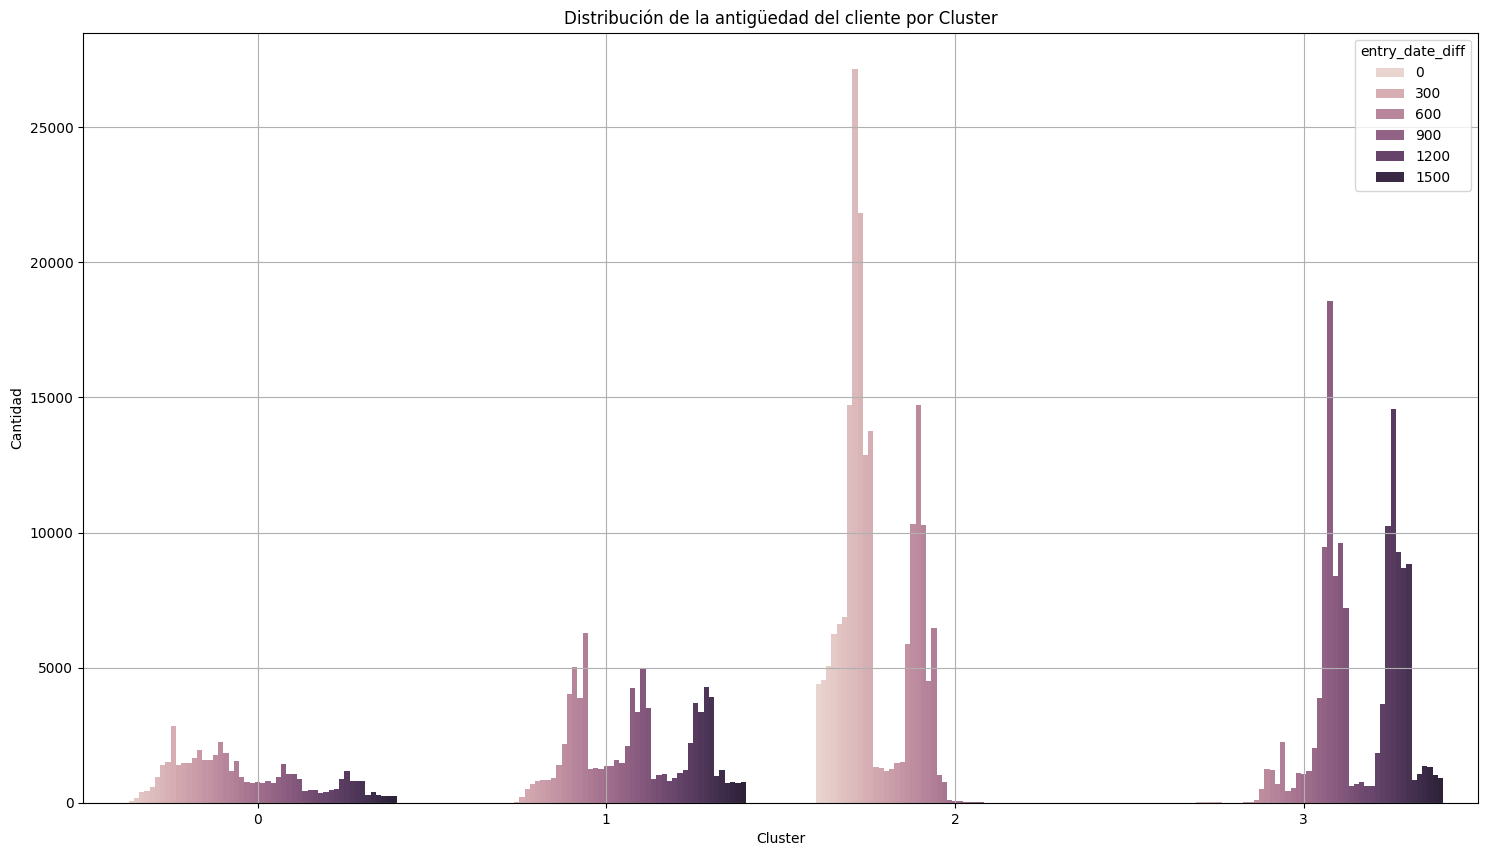

In [58]:
plt.figure(figsize=(18, 10))
sns.countplot(x='cluster', hue='entry_date_diff', data=X_processed)
plt.title('Distribución de la antigüedad del cliente por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Cantidad')
plt.grid(True)
plt.show()

#### Distribución de las ventas por Cluster

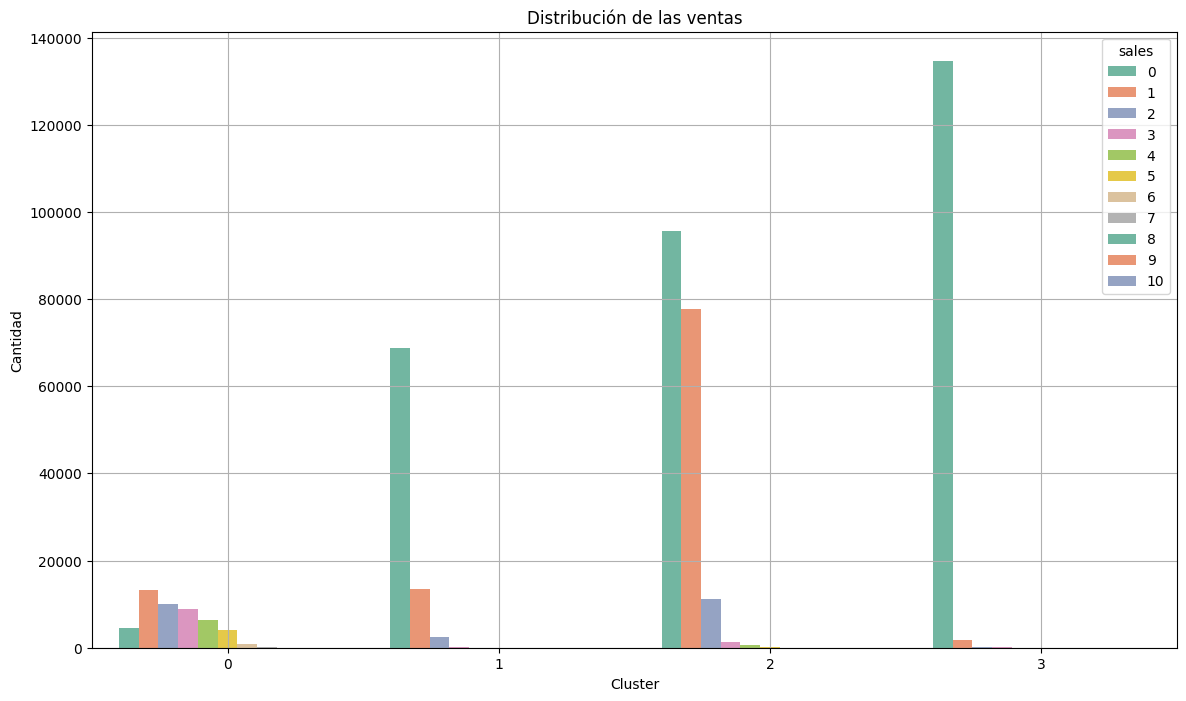

In [62]:
plt.figure(figsize=(14, 8))
sns.countplot(x='cluster', hue='sales', data=X_processed, palette='Set2')
plt.title('Distribución de las ventas')
plt.xlabel('Cluster')
plt.ylabel('Cantidad')
plt.grid(True)
plt.show()